<a href="https://colab.research.google.com/github/Sam-Joshua-S/Face-and-palm-Recognition/blob/main/Prototype_Layer_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [ ]:
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [ ]:
!wget https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
!rm -rf data
!unzip "at&t.zip" -d .

--2022-10-09 19:07:18--  https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip [following]
--2022-10-09 19:07:19--  https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3797060 (3.6M) [application/zip]
Saving to: ‘at&t.zip’

at&t.zip            100%[===================>]   3.62M  --.-KB/s    in 0.01s   

2022-10-09 19:07:19 (315 MB/s) - ‘at&t.zip’ saved [3797060/3797060]

Archive:  at&t.zip
   creating: ./data/
   creating

In [ ]:
# Load the training dataset
folder_dataset = datasets.ImageFolder(root="./data/faces/training/")

In [ ]:
# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

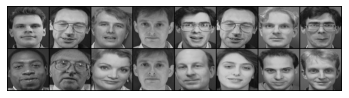

[1. 1. 1. 0. 1. 1. 1. 1.]


In [ ]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [ ]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [ ]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [ ]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

Epoch number 0
 Current loss 2.3728690147399902

Epoch number 1
 Current loss 1.1307964324951172

Epoch number 2
 Current loss 0.7950469255447388

Epoch number 3
 Current loss 0.9009856581687927

Epoch number 4
 Current loss 0.8898314237594604

Epoch number 5
 Current loss 0.8569235801696777

Epoch number 6
 Current loss 0.8227921724319458

Epoch number 7
 Current loss 0.5503821969032288

Epoch number 8
 Current loss 0.5784999132156372

Epoch number 9
 Current loss 0.6190271377563477

Epoch number 10
 Current loss 0.33016157150268555

Epoch number 11
 Current loss 0.5508249998092651

Epoch number 12
 Current loss 0.5418422222137451

Epoch number 13
 Current loss 0.4822700321674347

Epoch number 14
 Current loss 0.5870709419250488

Epoch number 15
 Current loss 0.41666993498802185

Epoch number 16
 Current loss 0.3398783802986145

Epoch number 17
 Current loss 0.3560512661933899

Epoch number 18
 Current loss 0.33483484387397766

Epoch number 19
 Current loss 0.45024925470352173

Epoch 

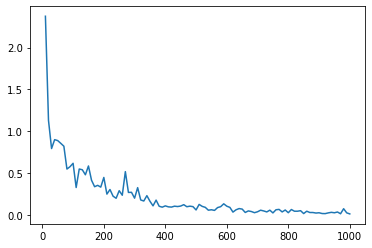

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

# Iterate throught the epochs
for epoch in range(100):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

torch.Size([1, 1, 100, 100]) torch.Size([1, 1, 100, 100])


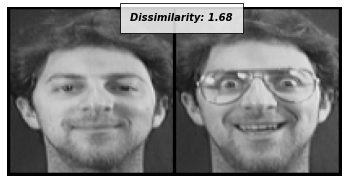

torch.Size([1, 1, 100, 100]) torch.Size([1, 1, 100, 100])


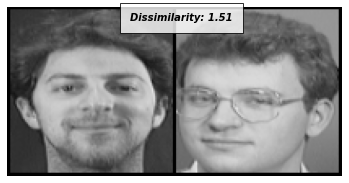

torch.Size([1, 1, 100, 100]) torch.Size([1, 1, 100, 100])


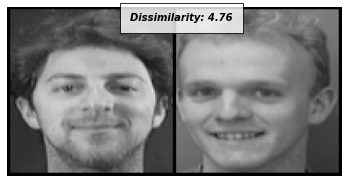

torch.Size([1, 1, 100, 100]) torch.Size([1, 1, 100, 100])


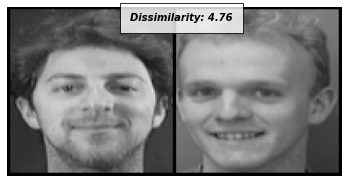

torch.Size([1, 1, 100, 100]) torch.Size([1, 1, 100, 100])


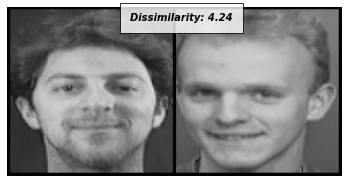

torch.Size([1, 1, 100, 100]) torch.Size([1, 1, 100, 100])


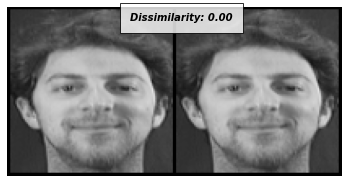

torch.Size([1, 1, 100, 100]) torch.Size([1, 1, 100, 100])


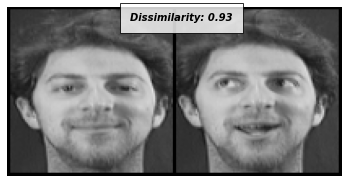

torch.Size([1, 1, 100, 100]) torch.Size([1, 1, 100, 100])


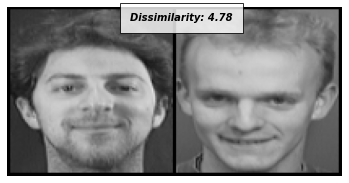

torch.Size([1, 1, 100, 100]) torch.Size([1, 1, 100, 100])


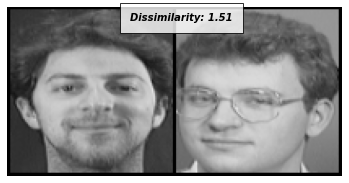

torch.Size([1, 1, 100, 100]) torch.Size([1, 1, 100, 100])


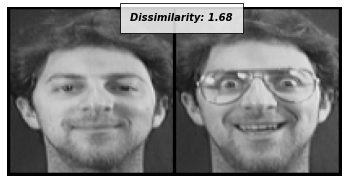

In [ ]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="./data/faces/testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)
    print(x0.shape,x1.shape)
    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

In [ ]:
x0.shape

torch.Size([1, 1, 100, 100])

In [ ]:
import cv2

In [ ]:
!wget http://alereimondo.no-ip.org/OpenCV/uploads/34/frontalFace10.zip -O harr.zip
!unzip harr.zip

--2022-10-09 19:52:45--  http://alereimondo.no-ip.org/OpenCV/uploads/34/frontalFace10.zip
Resolving alereimondo.no-ip.org (alereimondo.no-ip.org)... 181.167.159.187
Connecting to alereimondo.no-ip.org (alereimondo.no-ip.org)|181.167.159.187|:80... failed: Connection timed out.
Retrying.

--2022-10-09 19:54:55--  (try: 2)  http://alereimondo.no-ip.org/OpenCV/uploads/34/frontalFace10.zip
Connecting to alereimondo.no-ip.org (alereimondo.no-ip.org)|181.167.159.187|:80... ^C
Archive:  harr.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of harr.zip or
        harr.zip.zip, and cannot find harr.zip.ZIP, period.


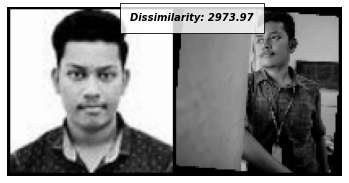

In [ ]:
img1 = cv2.imread('jai.jpg')
img2 = cv2.imread('jaik.jpg')
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
x0 = cv2.resize(gray1,(100,100))
x1 = cv2.resize(gray2,(100,100))
x0=(torch.from_numpy(x0.reshape(1,1,100,100))).float()
x1=(torch.from_numpy(x1.reshape(1,1,100,100))).float()

concatenated = torch.cat((x0, x1), 0).byte()
    
output1, output2 = net(x0.cuda(), x1.cuda())
euclidean_distance = F.pairwise_distance(output1, output2)
imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

In [2]:
pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.5 MB 1.2 MB/s 


In [3]:
import mediapipe as mp

In [4]:
mp_drawing = mp.solutions.drawing_utils
# load face detection model
mp_face = mp.solutions.face_detection.FaceDetection(
    model_selection=1, # model selection
    min_detection_confidence=0.5 # confidence threshold
)

In [5]:
image = cv2.imread('image0.png')
image_input = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# get results
results = mp_face.process(image_input)

if not results.detections:
    print('No faces detected.')
else:
    for detection in results.detections: # iterate over each detection and draw on image
      mp_drawing.draw_detection(image, detection)

cv2.imwrite('image0-pred.jpg', image)

NameError: ignored

In [ ]:
detection_results= []
for detection in results.detections:
    bbox = detection.location_data.relative_bounding_box
    bbox_points = {
        "xmin" : int(bbox.xmin * width),
        "ymin" : int(bbox.ymin * height),
        "xmax" : int(bbox.width * width + bbox.xmin * width),
        "ymax" : int(bbox.height * height + bbox.ymin * height)
    }

    detection_results.append(bbox_points)

In [ ]:
FACIAL_KEYPOINTS = mp.solutions.face_detection.FaceKeyPoint

for detection in results.detections:
    # Landmarks
    keypoints = {}
    for kp in FACIAL_KEYPOINTS: # iterate over each landmarks and get from results
        keypoint = mp.solutions.face_detection.get_key_point(detection, kp)
        # convert to pixel coordinates and add to dictionary
        keypoints[kp.name] = {"x" : int(keypoint.x * width), "y" : int(keypoint.y * height)}
        
    # bbox data
    bbox = detection.location_data.relative_bounding_box
    bbox_points = {
        "xmin" : int(bbox.xmin * width),
        "ymin" : int(bbox.ymin * height),
        "xmax" : int(bbox.width * width + bbox.xmin * width),
        "ymax" : int(bbox.height * height + bbox.ymin * height)
    }

    # add score, bbox and keypoints to detection_results
    detection_results.append({
        "keypoints" : keypoints,
        "bbox" : bbox_points,
        "score" : detection.score
    })